# 0. Prerequisite: setup the environment
----

In [2]:
# reload module when it is modified
%reload_ext autoreload
%autoreload 2


# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

# import required libraries
import numpy as np
import scipy.io.wavfile as wav
import pyACA

# import visualize module
from utils.visualize import *
# read the audio file

# TODO: Make sure the audio file is ready in ./asset
f_s, wav = pyACA.ToolReadAudio('asset/pitch/01-D_AMairena.wav')
print('Sampling rate: %.2f Hz' % f_s)
print('Number of samples: %d' % wav.size)

Sampling rate: 44100.00 Hz
Number of samples: 1138432


# 1. Audio Preprocessing
---

### Reference  
**Slides:** [ACA-Input-Pre-Processing](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/03-02-ACA-Input-Pre-Processing.pdf)

### Summary  
Audio preprocessing involves task-specific transformations applied to audio data before further processing, such as feature extraction. Common preprocessing steps include:

1. **Downmixing** – Converts multi-channel audio to mono by removing spatial information that may be irrelevant to the task.  
2. **Normalization** – Adjusts amplitude levels to improve consistency and robustness across different recordings.  
1. **Downsampling** – Reduces the sample rate to decrease data size while retaining essential information.  




### 1.1 Downmixing
Downmixing mono audio $x(i)$ data can be computed by the equation below:
$$
    x(i)= \frac{1}{C}\sum_{c=0}^{C-1} x_c(i)
$$

where $C$ is total number of audio channel (e.g. 2 for stereo audio), 
$i$ is the sample position.

Take a look at the implementation in pyACA - [ToolDownmix](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/ToolDownmix.py). Here is a example:


In [ ]:
from pyACA import ToolDownmix
# TODO: bad example, would find a steroe file

# read audio, check number of channels
fs, x = pyACA.ToolReadAudio('asset/pitch/01-D_AMairena.wav', )
print('original number of channels: %d' % 1 if x.ndim == 1 else x.shape[-1])

# downmix, check number of channels
x = ToolDownmix(x)
print('new number of channels: %d' % 1 if x.ndim == 1 else x.shape[-1])


original number of channels: 1
new number of channels: 1


### 1.2 Normalization
Normalized audio $x(i)$ data can be computed by the equation below:
$$
    x(i) = \frac{x_s(i)}{\max\limits_{\forall i}|x_s(i)| }
$$
where $x_s$ is original audio input, 
$i$ is the sample position.

Take a look at the implementation in pyACA - [ToolNormalizeAudio](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/ToolNormalizeAudio.py). Here is a example:


In [18]:
from pyACA import ToolNormalizeAudio
# normalize audio, check min/max
fs, x = pyACA.ToolReadAudio('asset/pitch/01-D_AMairena.wav', )
print('original min: %.2f; max: %.2f' % (np.min(x), np.max(x)))

x = ToolNormalizeAudio(x)
print('new min: %.2f; max: %.2f' % (np.min(x), np.max(x)))

original min: -0.69; max: 0.92
new min: -0.75; max: 1.00



# 1. Blocking the audio
----
#### References
Text book: [Sect. 3.2.5](https://ieeexplore.ieee.org/document/9966260)
Slides: [ACA-Input-Blocking](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/03-02-05-ACA-Input-Blocking.pdf)

#### Summary
Commonly, the time series of an audio signal is split into blocks for analysis. This is required for the implementation of real-time systems that work stream based (as opposed to file-based), but it is also common for non-real time systems, because it
1. Allows for resource-efficient implementation (allocated memory, SIMD instructions), and
2. Is aligned with often-used algorithms with fixed-length input such as the Fourier Transform.

### 1.1 Implementation of a non-realtime audio blocking function in pyACA: [`ToolBlockAudio`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/ToolBlockAudio.py])

```python
def ToolBlockAudio(x, iBlockLength, iHopLength, f_s):
    # 1. Calculate the number of blocks
    iNumBlocks = np.ceil(x.shape[0] / iHopLength).astype(int)
    # 2. Get the time stamp vector
    t = np.arange(0, iNumBlocks) * iHopLength / f_s + iBlockLength / (2*f_s)
    # 3. Pad with block length zeros just to make sure it runs for weird inputs, too
    afAudioPadded = np.concatenate((x, np.zeros([iBlockLength+iHopLength, ])), axis=0)
    # 4. Return block value
    return np.vstack([np.array(afAudioPadded[n*iHopLength:n*iHopLength+iBlockLength]) for n in range(iNumBlocks)]), t


In [ ]:

import pyACA
from pyACA import ToolBlockAudio
f_s, wav = pyACA.ToolReadAudio('asset/pitch/01-D_AMairena.wav')

# Here, the numbers for block size and hop size are arbitrarily picked, with the following caveats:
# 1. hop size should always be smaller than block size and is most commonly half the block size
# 2. typical block sizes for high quality audio signals range from 512 samples to 16,384 samples
# 3. block sizes that are powers of two are common because they can align easily with Fourier transform block sizes
iBlockLength, iHopLength = 2048, 1024
afBlockWav, block_time = ToolBlockAudio(wav, iBlockLength=iBlockLength, iHopLength=iHopLength, f_s=f_s)
print(f'Original audio data with length {wav.shape[0]} is blocked into {afBlockWav.shape[0]} blocks with {afBlockWav.shape[1]} samples each')


Original audio data with length 1138432 is blocked into 1112 blocks with 2048 samples each


### 1.2 Visualization of the blocked signal
You can adjust the block size and hop size below to observe how a single block covers the signal.

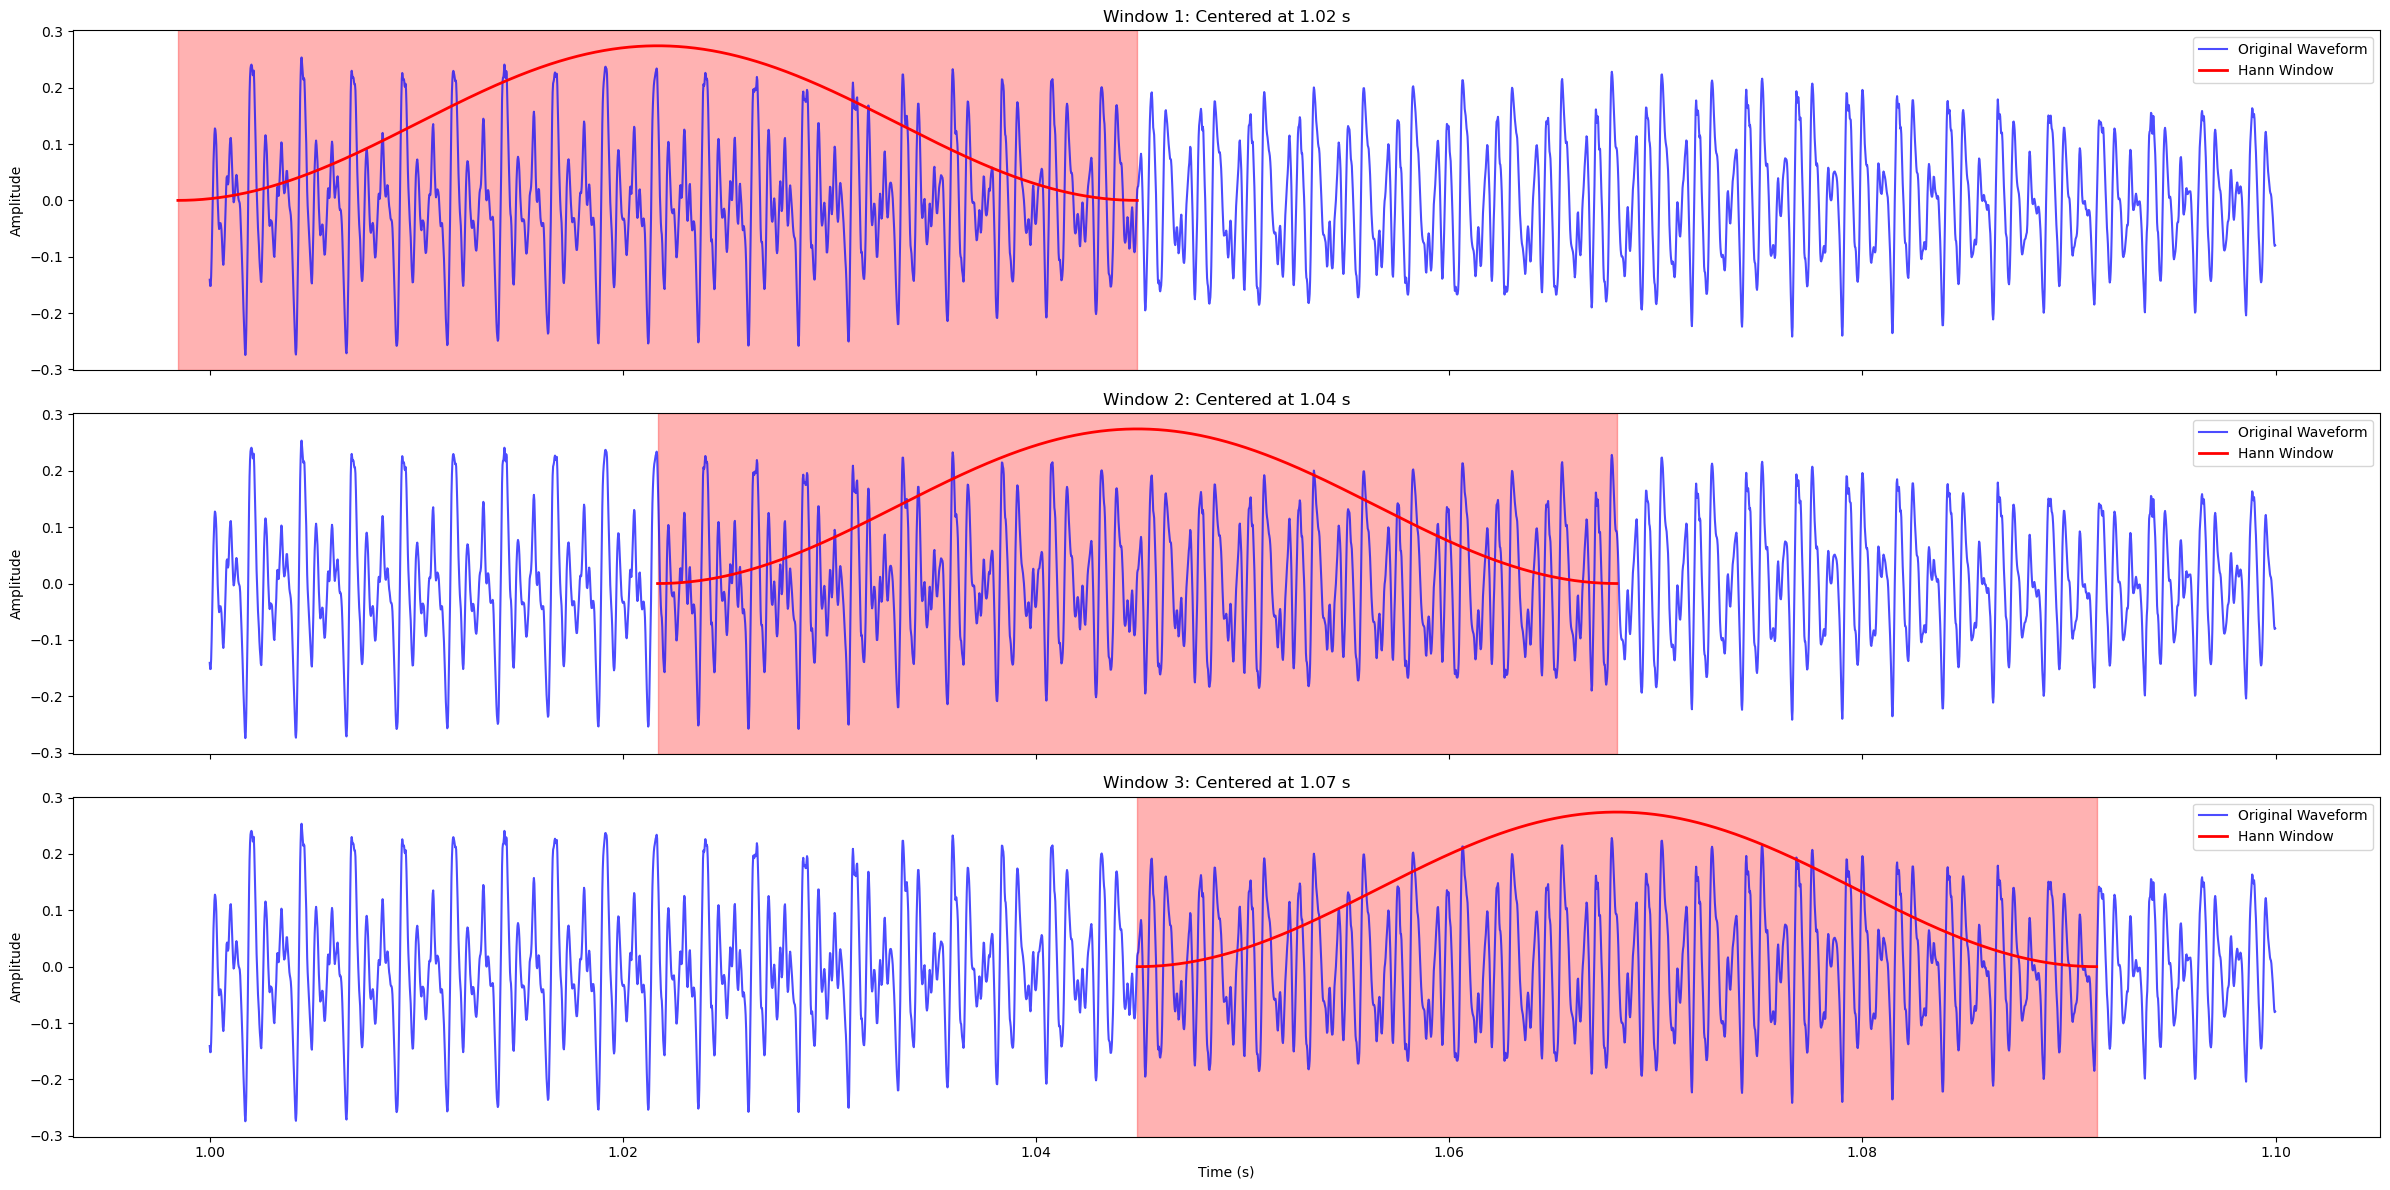

In [35]:


try: window_size = iBlockLength
except: 
    f_s, wav = pyACA.ToolReadAudio('asset/pitch/01-D_AMairena.wav')
    iBlockLength, iHopLength = 2048, 1024
    afBlockWav, block_time = ToolBlockAudio(wav, iBlockLength=iBlockLength, iHopLength=iHopLength, f_s=f_s)

visualAudioBlock(blockTime=block_time, origAudio=wav, window_size=iBlockLength, fs=f_s)

# TODO window (Hann) shifting visualization

# 2. Short-Time Fourier Transform and Spectrogram
---
#### References
Text book: [Sect. 3.3.1](https://ieeexplore.ieee.org/document/9966260)
Slides: [ACA-Input-TF-Fourier](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/03-03-01-ACA-Input-TF-Fourier.pdf)

#### Summary
The Fourier transform is a very common representation for audio analysis. Most commonly, the discrete Fourier transform is computed over short, overlapping blocks of the audio signal. The magnitude of the Fourier result is often combined in a pseudo-3D representation: the /spectrogram/. It provides a time-frequency view of the signal, highlighting the magnitude of a specific frequency at a specific point in time in color. The spectrogram is a common input representation for a large variety of audio analysis tasks.

## 2.1 Discrete Fourier Transform
#TODO: add equations
The default way to compute the discrete fourier transformation (DFT) comes with a complexity $O(N^2)$.


In [4]:
def dft(x):
    N = len(x)
    # Initialize output array
    X = np.zeros(N, dtype=complex)  

    # Loop over output frequencies
    for k in range(N):
        # Loop over input signal
        for n in range(N):  
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)  # Multiply by twiddle factor
    return X

## 2.2 Fast Fourier Transform
The workload produced by the function $dft(x)$ grows quadratically $O(N^2)$ with increasing block length $N$, making it inefficient for large input blocks. An efficient way to compute the DFT is the Fast Fourier Tranform (FFT), utlilizing the **Divide and Conquer** technique to optimize the computational complexity to $O(N\log N)$ while yielding identical results.

In [5]:
import numpy as np

def fft(x):
    N = len(x)
    if N <= 1:
        return x  # Base case: Return single element

    # Recursively compute FFT of even and odd indexed elements
    even_part = fft(x[0::2])
    odd_part = fft(x[1::2])

    # Compute twiddle factors
    T = [np.exp(-2j * np.pi * k / N) * odd_part[k] for k in range(N // 2)]

    # Combine the results
    return [even_part[k] + T[k] for k in range(N // 2)] + \
           [even_part[k] - T[k] for k in range(N // 2)]

For example, if processing with the signal of $[1,2,3,4,5,6,7,8]$. According to divide and conquer algorithmn, the process would be process recursively like:

```python
fft([1, 2, 3, 4, 5, 6, 7, 8])
 ├─ fft([1, 3, 5, 7])
 │   ├─ fft([1, 5])
 │   │   ├─ fft([1]) → Base case
 │   │   ├─ fft([5]) → Base case
 │   ├─ fft([3, 7])
 │       ├─ fft([3]) → Base case
 │       ├─ fft([7]) → Base case
 ├─ fft([2, 4, 6, 8])
 │   ├─ fft([2, 6])
 │   │   ├─ fft([2]) → Base case
 │   │   ├─ fft([6]) → Base case
 │   ├─ fft([4, 8])
 │       ├─ fft([4]) → Base case
 │       ├─ fft([8]) → Base case


Let's compare the processing time for `dft` and `fft`:

In [6]:
from utils.base import compare_runtime
input_sequence = np.random.rand(1024)
t1, t2 = compare_runtime(dft, fft, input_sequence, num_runs=1)
print(f"Runtime of DFT: {t1} ms")
print(f"Runtime of FFT: {t2} ms")

Runtime of DFT: 0.911191167018842 ms
Runtime of FFT: 0.00516141700791195 ms


## 2.3 Short Time Fourier Transform (STFT)
We block the audio into blocks using `ToolBlockAudio()` and compute the FFT for every segment. Be aware that before `fft`, we have to apply the window function. Directly computing the FFT of the blocked audio would assume a rectangular window function which produces a significant amount of spectral leakage; thus, other window types such as the [Hann window](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/ToolComputeHann.py) are usually preferred:
The Hann window can be pre-computed with $w(n)=\frac{1}{2}(1 - \cos(\frac{2\pi n}{N}))$

```python
def ToolComputeHann(iWindowLength):
    return 0.5 - (0.5 * np.cos(2 * np.pi / iWindowLength * np.arange(iWindowLength)))
```

The function [`computeSpectrogram`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/computeSpectrogram.py) implements many of these details with useful default settings.

Now, let's plot the spectrogram of a sine wave signal. Notice that the magnitude is precisely centered at the sine wave's frequency:

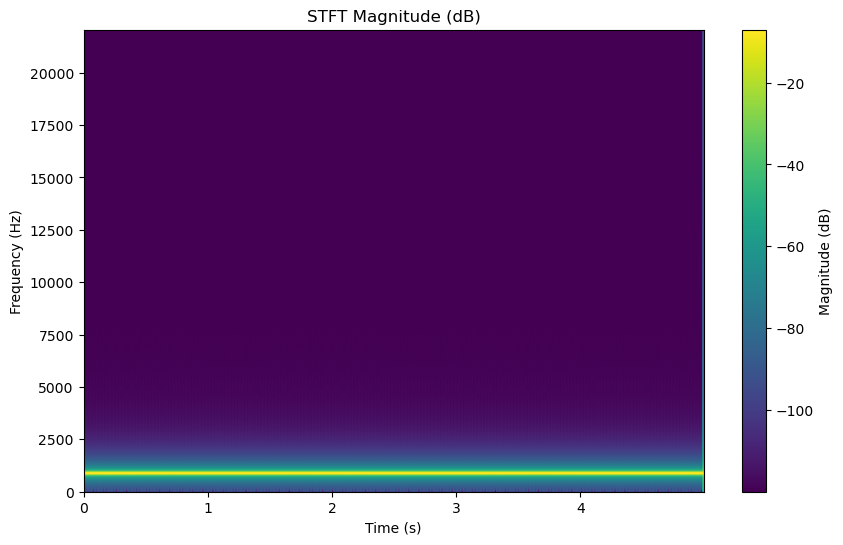

In [9]:
from utils.base import sineWavGen
from pyACA import computeSpectrogram

wav, fs, _ = sineWavGen(880, duration=5, sr=44100)
X, f, t = computeSpectrogram(wav, fs, iBlockLength=1024, iHopLength=512)
visualizeSpec(X, sr=fs, hop_length=512)

We can also apply this visualization on any oridnary audio clip. Here, we load a randon audio file and provide its spectrogram in magnitude and log magnitude (dB) 


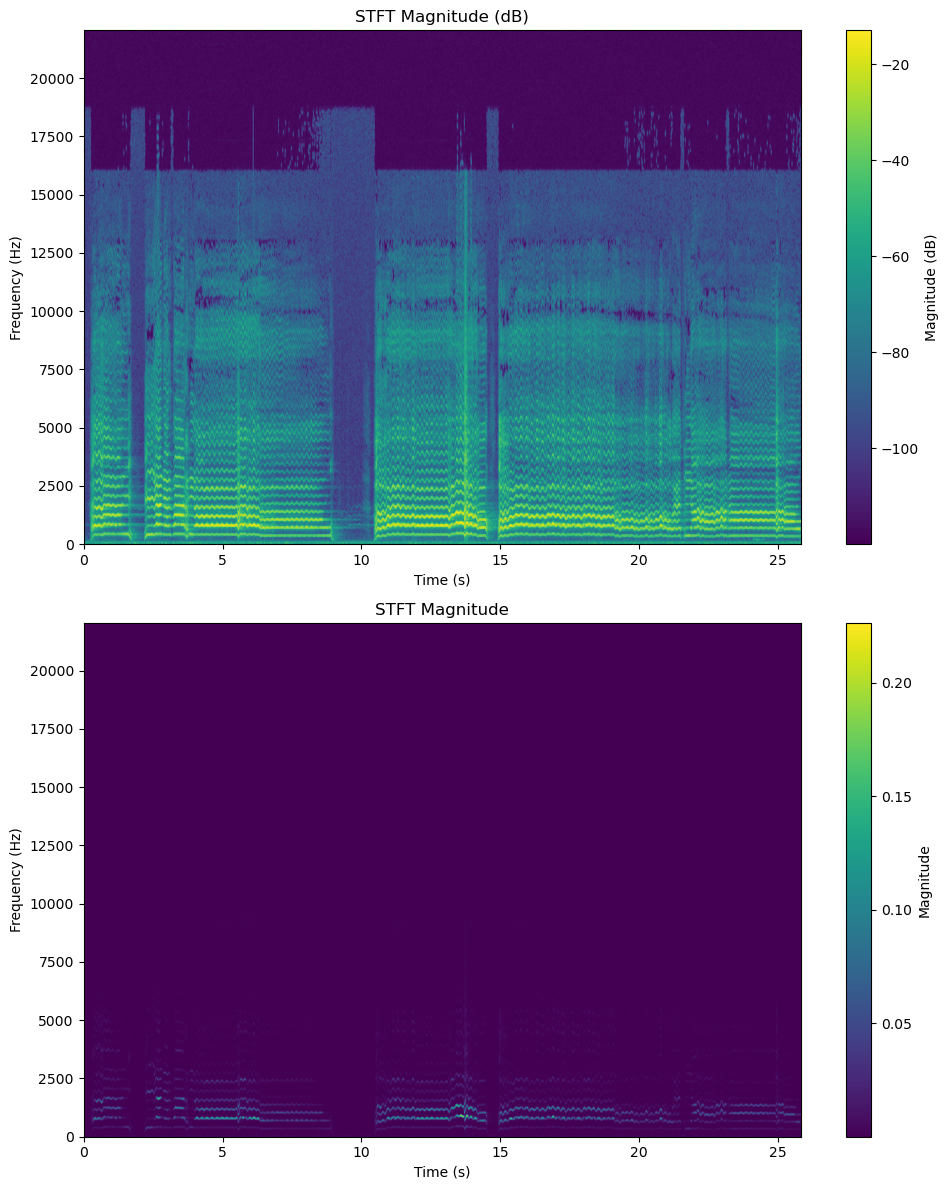

In [ ]:

# Load waveform
f_s, wav = pyACA.ToolReadAudio('asset/pitch/01-D_AMairena.wav')
# Compute spectrogram
X, f, t = computeSpectrogram(wav, fs, iBlockLength=1024, iHopLength=512)
# Visualize spectrogram
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
visualizeSpec(X, f_s, hop_length=512, log_magnitude=True, ax=axes[0])
visualizeSpec(X, f_s, hop_length=512, log_magnitude=False, ax=axes[1])
plt.tight_layout()
plt.show()

## 2.4 Mel Spectrogram

The Mel spectrogram provides a perceptually relevant representation of audio by mapping the linear frequency bins of the power spectrogram onto the Mel scale. The transformation emphasizes the frequency components that are most important for human hearing, making it useful for applications in speech and music analysis. The conversion to the Mel scale can be expressed as:
$$
    M(m) = \sum_{k=0}^{N-1} |X(k)|^2 \cdot H_m(k)
$$

where $H_m(k)$ represents the $m$-th Mel filter, and $|X(k)|^2$ is the power at the $k$-th frequency bin.

We can take a look at [`computeMelSpectrogram`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/computeMelSpectrogram.py) in pyACA for more details.

Now, let's plot the Mel spectrogram of a audio signal and observe how its energy is distributed along the Mel frequency axis:

(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Mel Spectrogram'}, xlabel='Time (s)', ylabel='Frequency (Hz)'>,
 <matplotlib.collections.QuadMesh at 0x176022410>)

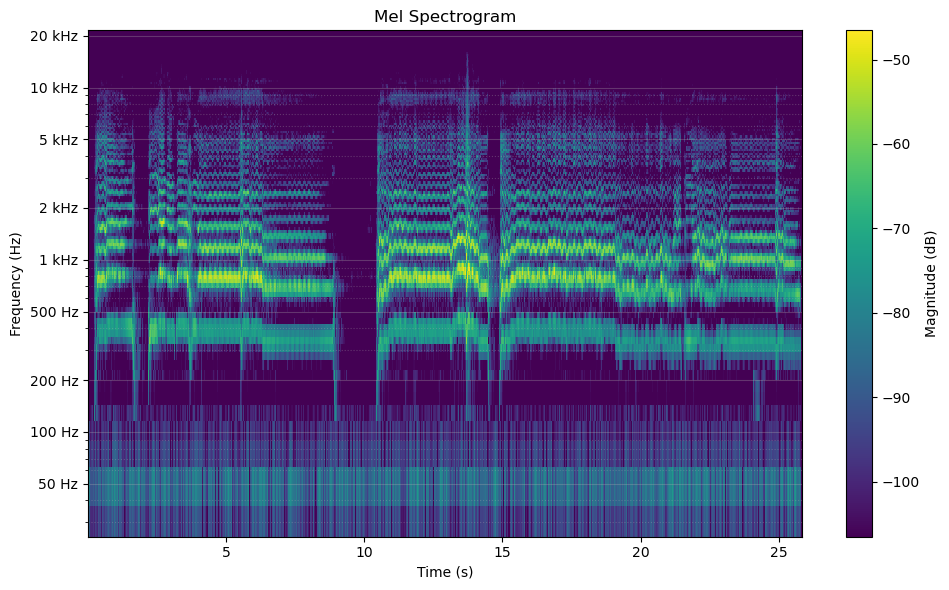

In [9]:
from pyACA import computeMelSpectrogram
f_s, wav = pyACA.ToolReadAudio('asset/pitch/01-D_AMairena.wav')
# Compute spectrogram
M, f_c, t = computeMelSpectrogram(wav, f_s, iBlockLength=1024, iHopLength=512, iNumMelBands=128)
# Visualize spectrogram
visualizeMelSpectrogram(M, f_c, t)
